# Train / load pretrained models

In [ ]:
train_general = False

train_gk = False
train_def = False
train_mid = False
train_fwd = False

# Google Colab / Kaggle / PC

In [ ]:
mode = "Colab"

In [ ]:
import os

if mode == "Colab":
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "PC":
    os.chdir("D:\PulpitE\FPL_ML")
    TRAIN_PATH = "data/previous/final_dataset.csv"
if mode == "Kaggle":
    TRAIN_PATH = "/kaggle/input/fpl-dataset/final_dataset.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports

In [ ]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [ ]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - minimal number of gameweeks required for a player
FFP = 15

FIRST_TRAIN_GW = 9
LAST_TRAIN_GW = 20

FIRST_VALID_GW = 21
LAST_VALID_GW = 21

# NEXT_GAMEWEEK = 22
# LAST_GAMEWEEK = NEXT_GAMEWEEK - 1

In [ ]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Device

In [ ]:
# device = torch.device("cuda")
# device = torch.device('mps')
device = torch.device('cpu')

# Getting data and choosing features

In [ ]:
df = pd.read_csv('data/previous/final_dataset.csv')

In [ ]:
# remembering original dataframes
df_original = df

df_gk_original = df[df["FPL position"] == "GK"]
df_def_original = df[df["FPL position"] == "DEF"]
df_mid_original = df[df["FPL position"] == "MID"]
df_fwd_original = df[df["FPL position"] == "FWD"]

In [ ]:
# df_original.columns

In [ ]:
info = ["Name", "GW", "FPL position"]
other = ["LSTM"]
features = ["Min", "Gls", "Ast", "Sh", "SoT", "xG", "npxG", "xAG", "SCA", "GCA", "CS", "CrdY", "CrdR", "Opp rating", "Team Score", "Opp Score", "Was Home"]
to_predict = ["Total Points"]

In [ ]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
df.shape

(7457, 21)

In [ ]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking only players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [ ]:
df.shape

(5771, 21)

In [ ]:
# df.head(20)

In [ ]:
last_names = df["Name"].unique()

# DF to DataLoader

In [ ]:
df_train = df[df["GW"] <= LAST_TRAIN_GW]
df_valid = df

# gk, def, mid, fwd
df_gk_train = df[(df["FPL position"] == "GK") & (df["GW"] <= LAST_TRAIN_GW)]
df_gk_valid = df[(df["FPL position"] == "GK") ]

df_def_train = df[(df["FPL position"] == "DEF") & (df["GW"] <= LAST_TRAIN_GW)]
df_def_valid = df[(df["FPL position"] == "DEF") ]

df_mid_train = df[(df["FPL position"] == "MID") & (df["GW"] <= LAST_TRAIN_GW)]
df_mid_valid = df[(df["FPL position"] == "MID") ]

df_fwd_train = df[(df["FPL position"] == "FWD") & (df["GW"] <= LAST_TRAIN_GW)]
df_fwd_valid = df[(df["FPL position"] == "FWD")]

In [ ]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [ ]:
class PandasDataset(Dataset):
    def __init__(self, dataframe, starting_gw, ending_gw):
        self.dataframe = dataframe
        
        self.names = dataframe["Name"].unique()
        self.starting_gw = starting_gw
        self.ending_gw = ending_gw
        self.cut_unused_rows()
        self.length = self.calculate_length()
        self.names = self.dataframe["Name"].unique()

        self.index_table = init_index_table(self.dataframe)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def cut_unused_rows(self):
        for name in self.names:
            df_name = self.dataframe[self.dataframe["Name"] == name]
            name_length = df_name.shape[0]
            # print("NAME LENGTH", name, name_length, FIS + 1)
            if name_length >= FIS + 1:
                try:
                    first_index = df_name.index.tolist()[0]
                except IndexError:
                    first_index = None

                try:
                    print(self.starting_gw, df_name["GW"].tolist())
                    if self.starting_gw not in df_name["GW"].tolist():
                        last_index = max(FIS, sorted(df_name.index[df_name['GW'] < self.starting_gw].tolist())[-1]) - FIS
                    else:
                        # print(df_name.index[df_name['GW'] == self.starting_gw].tolist()[0])
                        print("LAST INDEX v2", max(FIS, df_name.index[df_name['GW'] == self.starting_gw].tolist()[0] - 1) - FIS)
                        last_index = max(FIS, df_name.index[df_name['GW'] == self.starting_gw].tolist()[0] - 1) - FIS
                except:
                    last_index = None

                print("FIRST LAST INDEX", name, first_index, last_index)
                # print("FIRST", self.dataframe.loc[first_index])
                # print("LAST", self.dataframe.loc[last_index])
                if first_index != None and last_index != None:
                    # print("WYCIETO", name, range(first_index, last_index + 1))
                    self.dataframe = self.dataframe.drop(range(first_index, last_index + 1))
            else:
                print("DROPPING", name, [df_name.index.tolist()])
                # removing all rows of this player
                # self.dataframe = self.dataframe.drop(df_name.index.tolist())
                self.dataframe = self.dataframe[self.dataframe["Name"] != name]

            # no fixtures played in [start_gw, end_gw] period
            # print("SET A", set(df_name["GW"].tolist()))
            # print("SET B", set(range(self.starting_gw, self.ending_gw + 1)))
            # print("INTERSECT", set(df_name["GW"].tolist()) & set(range(self.starting_gw, self.ending_gw + 1)))
            if list(set(df_name["GW"].tolist()) & set(range(self.starting_gw, self.ending_gw + 1))) == []:
                # removing all rows of this player
                # self.dataframe = self.dataframe.drop(df_name.index.tolist())
                self.dataframe = self.dataframe[self.dataframe["Name"] != name]
                

            # print("CUTTING", name, first_index, last_index, name_length)
            # print("CUT2", df_name.index[df_name['GW'] < self.starting_gw].tolist())
            # print(self.dataframe.shape)
            # print("")

    def calculate_length(self):
        length = 0
        for name in self.names:
            # print(name, (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS))
            length += max(self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS, 0)
        return length

    def get_items_info(self):
        gws = []
        for i in range(self.__len__()):
            player_id, sample_id = self.index_table[i]
            name = self.names[player_id]
            gw = self.dataframe[self.dataframe["Name"] == name].iloc[(sample_id + FIS)]["GW"]
            gws.append(gw)
        return pd.DataFrame(gws)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = self.index_table[idx]
        name = self.names[player_id]
        # print(name)
        # print("GETITEM DF", name, player_id, sample_id)

        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        # print("GETITEM", idx, player_id, sample_id, name)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [ ]:
dataset_general_train = PandasDataset(df_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_general_valid = PandasDataset(df_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_gk_train = PandasDataset(df_gk_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_gk_valid = PandasDataset(df_gk_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_def_train = PandasDataset(df_def_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_def_valid = PandasDataset(df_def_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_mid_train = PandasDataset(df_mid_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_mid_valid = PandasDataset(df_mid_valid, FIRST_VALID_GW, LAST_VALID_GW)

9 [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
LAST INDEX v2 0
FIRST LAST INDEX Brenden-Aaronson 0 0
9 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
LAST INDEX v2 17
FIRST LAST INDEX Che-Adams 19 17
9 [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20]
LAST INDEX v2 36
FIRST LAST INDEX Tyler-Adams 39 36
9 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 7, 20]
LAST INDEX v2 54
FIRST LAST INDEX Tosin-Adarabioyo 56 54
9 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
LAST INDEX v2 81
FIRST LAST INDEX Rayan-Ait-Nouri 83 81
9 [1, 2, 3, 6, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 7]
LAST INDEX v2 122
FIRST LAST INDEX Nathan-Ake 126 122
9 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
LAST INDEX v2 141
FIRST LAST INDEX Marc-Albrighton 143 141
9 [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
LAST INDEX v2 174
FIRST LAST INDEX Trent-Alexander-Arnold 177 174
9 [1, 2, 3, 4, 5,

In [ ]:
dataset_fwd_train = PandasDataset(df_fwd_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
print("")
dataset_fwd_valid = PandasDataset(df_fwd_valid, FIRST_VALID_GW, LAST_VALID_GW)

9 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
LAST INDEX v2 17
FIRST LAST INDEX Che-Adams 19 17
9 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 7]
LAST INDEX v2 236
FIRST LAST INDEX Julian-Alvarez 238 236
9 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
LAST INDEX v2 327
FIRST LAST INDEX Michail-Antonio 329 327
9 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
LAST INDEX v2 410
FIRST LAST INDEX Adam-Armstrong 412 410
9 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
LAST INDEX v2 504
FIRST LAST INDEX Taiwo-Awoniyi 506 504
9 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
LAST INDEX v2 1549
FIRST LAST INDEX Patson-Daka 1551 1549
9 [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
LAST INDEX v2 1717
FIRST LAST INDEX Emmanuel-Dennis 1721 1717
9 [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 7]
LAST INDEX v2 2045
FIRST LAST INDEX Odsonne-Edouard 2048 2045

In [ ]:
df_fwd_train[df_fwd_train["Name"] == "Erling-Haaland"]

,Name,GW,FPL position,Min,Gls,Ast,Sh,SoT,xG,npxG,...,SCA,GCA,CS,CrdY,CrdR,Opp rating,Team Score,Opp Score,Was Home,Total Points
2886,Erling-Haaland,1,FWD,77.0,2.0,0.0,4.0,1.0,1.7,0.9,...,3.0,1.0,1.0,0.0,0.0,1783.215088,2.0,0.0,0.0,13.0
2887,Erling-Haaland,2,FWD,73.0,0.0,1.0,2.0,1.0,0.1,0.1,...,1.0,1.0,1.0,0.0,0.0,1644.115601,4.0,0.0,1.0,5.0
2888,Erling-Haaland,3,FWD,90.0,1.0,0.0,4.0,3.0,0.7,0.7,...,4.0,0.0,0.0,0.0,0.0,1764.226318,3.0,3.0,0.0,6.0
2889,Erling-Haaland,4,FWD,83.0,3.0,0.0,7.0,3.0,1.4,1.4,...,0.0,0.0,0.0,0.0,0.0,1761.431274,4.0,2.0,1.0,17.0
2890,Erling-Haaland,5,FWD,68.0,3.0,0.0,4.0,3.0,1.6,1.6,...,1.0,1.0,1.0,0.0,0.0,1617.610229,6.0,0.0,1.0,17.0
2891,Erling-Haaland,6,FWD,90.0,1.0,0.0,3.0,3.0,0.9,0.9,...,3.0,0.0,0.0,0.0,0.0,1713.250488,1.0,1.0,0.0,9.0
2892,Erling-Haaland,8,FWD,90.0,1.0,0.0,2.0,2.0,0.1,0.1,...,2.0,1.0,1.0,0.0,0.0,1708.179321,3.0,0.0,0.0,6.0
2893,Erling-Haaland,9,FWD,90.0,3.0,2.0,6.0,3.0,1.1,1.1,...,5.0,2.0,0.0,0.0,0.0,1806.035278,6.0,3.0,1.0,23.0
2894,Erling-Haaland,10,FWD,90.0,1.0,0.0,5.0,1.0,0.7,0.7,...,1.0,0.0,1.0,0.0,0.0,1662.400391,4.0,0.0,1.0,6.0
2895,Erling-Haaland,11,FWD,90.0,0.0,0.0,6.0,4.0,0.5,0.5,...,3.0,0.0,0.0,0.0,0.0,1989.153687,0.0,1.0,0.0,2.0


In [ ]:
dataset_fwd_train.dataframe[dataset_fwd_train.dataframe["Name"] == "Erling-Haaland"]

,Name,GW,FPL position,Min,Gls,Ast,Sh,SoT,xG,npxG,...,SCA,GCA,CS,CrdY,CrdR,Opp rating,Team Score,Opp Score,Was Home,Total Points
2886,Erling-Haaland,1,FWD,77.0,2.0,0.0,4.0,1.0,1.7,0.9,...,3.0,1.0,1.0,0.0,0.0,1783.215088,2.0,0.0,0.0,13.0
2887,Erling-Haaland,2,FWD,73.0,0.0,1.0,2.0,1.0,0.1,0.1,...,1.0,1.0,1.0,0.0,0.0,1644.115601,4.0,0.0,1.0,5.0
2888,Erling-Haaland,3,FWD,90.0,1.0,0.0,4.0,3.0,0.7,0.7,...,4.0,0.0,0.0,0.0,0.0,1764.226318,3.0,3.0,0.0,6.0
2889,Erling-Haaland,4,FWD,83.0,3.0,0.0,7.0,3.0,1.4,1.4,...,0.0,0.0,0.0,0.0,0.0,1761.431274,4.0,2.0,1.0,17.0
2890,Erling-Haaland,5,FWD,68.0,3.0,0.0,4.0,3.0,1.6,1.6,...,1.0,1.0,1.0,0.0,0.0,1617.610229,6.0,0.0,1.0,17.0
2891,Erling-Haaland,6,FWD,90.0,1.0,0.0,3.0,3.0,0.9,0.9,...,3.0,0.0,0.0,0.0,0.0,1713.250488,1.0,1.0,0.0,9.0
2892,Erling-Haaland,8,FWD,90.0,1.0,0.0,2.0,2.0,0.1,0.1,...,2.0,1.0,1.0,0.0,0.0,1708.179321,3.0,0.0,0.0,6.0
2893,Erling-Haaland,9,FWD,90.0,3.0,2.0,6.0,3.0,1.1,1.1,...,5.0,2.0,0.0,0.0,0.0,1806.035278,6.0,3.0,1.0,23.0
2894,Erling-Haaland,10,FWD,90.0,1.0,0.0,5.0,1.0,0.7,0.7,...,1.0,0.0,1.0,0.0,0.0,1662.400391,4.0,0.0,1.0,6.0
2895,Erling-Haaland,11,FWD,90.0,0.0,0.0,6.0,4.0,0.5,0.5,...,3.0,0.0,0.0,0.0,0.0,1989.153687,0.0,1.0,0.0,2.0


In [ ]:
df_fwd_valid[df_fwd_valid["Name"] == "Dominic-Solanke"]

,Name,GW,FPL position,Min,Gls,Ast,Sh,SoT,xG,npxG,...,SCA,GCA,CS,CrdY,CrdR,Opp rating,Team Score,Opp Score,Was Home,Total Points
6302,Dominic-Solanke,1,FWD,89.0,0.0,0.0,3.0,1.0,0.2,0.2,...,1.0,0.0,1.0,0.0,0.0,1740.727295,2.0,0.0,1.0,2.0
6303,Dominic-Solanke,4,FWD,45.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2008.282349,0.0,9.0,0.0,1.0
6304,Dominic-Solanke,5,FWD,90.0,0.0,0.0,2.0,2.0,0.2,0.2,...,0.0,0.0,1.0,0.0,0.0,1712.072876,0.0,0.0,1.0,2.0
6305,Dominic-Solanke,6,FWD,89.0,1.0,1.0,1.0,1.0,0.1,0.1,...,1.0,1.0,0.0,0.0,0.0,1615.691284,3.0,2.0,0.0,12.0
6306,Dominic-Solanke,8,FWD,89.0,0.0,0.0,2.0,1.0,0.1,0.1,...,1.0,0.0,0.0,0.0,0.0,1756.879272,1.0,1.0,0.0,2.0
6307,Dominic-Solanke,9,FWD,90.0,0.0,0.0,1.0,0.0,0.1,0.1,...,2.0,0.0,1.0,0.0,0.0,1718.951416,0.0,0.0,1.0,2.0
6308,Dominic-Solanke,10,FWD,89.0,0.0,1.0,1.0,0.0,0.1,0.1,...,2.0,2.0,0.0,0.0,0.0,1734.542236,2.0,1.0,1.0,8.0
6309,Dominic-Solanke,11,FWD,88.0,1.0,1.0,2.0,2.0,0.3,0.3,...,2.0,2.0,0.0,0.0,0.0,1656.206543,2.0,2.0,0.0,12.0
6310,Dominic-Solanke,12,FWD,90.0,0.0,0.0,4.0,0.0,0.4,0.4,...,2.0,0.0,0.0,0.0,0.0,1668.365967,0.0,1.0,1.0,2.0
6311,Dominic-Solanke,13,FWD,44.0,0.0,0.0,2.0,2.0,0.2,0.2,...,1.0,0.0,0.0,0.0,0.0,1780.158813,0.0,2.0,0.0,1.0


In [ ]:
dataset_gk_train.__len__(), dataset_gk_valid.__len__()

(280, 25)

In [ ]:
dataset_def_train.__len__(), dataset_def_valid.__len__()

(982, 101)

In [ ]:
dataset_mid_train.__len__(), dataset_mid_valid.__len__()

(1317, 123)

In [ ]:
dataset_fwd_train.__len__(), dataset_fwd_valid.__len__()

(326, 30)

In [ ]:
df_fwd_valid[df_fwd_valid["Name"] == df_fwd_valid["Name"].unique()[2]]

,Name,GW,FPL position,Min,Gls,Ast,Sh,SoT,xG,npxG,...,SCA,GCA,CS,CrdY,CrdR,Opp rating,Team Score,Opp Score,Was Home,Total Points
329,Michail-Antonio,1,FWD,56.0,0.0,0.0,2.0,0.0,0.2,0.2,...,2.0,0.0,0.0,0.0,0.0,2025.362427,0.0,2.0,1.0,1.0
330,Michail-Antonio,2,FWD,67.0,0.0,0.0,2.0,0.0,0.1,0.1,...,3.0,0.0,0.0,0.0,0.0,1607.053101,0.0,1.0,0.0,2.0
331,Michail-Antonio,3,FWD,73.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1769.588623,0.0,2.0,1.0,2.0
332,Michail-Antonio,4,FWD,26.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1725.076172,1.0,0.0,0.0,1.0
333,Michail-Antonio,5,FWD,90.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1882.921753,1.0,1.0,1.0,5.0
334,Michail-Antonio,6,FWD,73.0,1.0,0.0,1.0,1.0,0.8,0.8,...,1.0,0.0,0.0,1.0,0.0,1873.998535,1.0,2.0,0.0,5.0
335,Michail-Antonio,8,FWD,69.0,0.0,0.0,2.0,1.0,0.2,0.2,...,1.0,0.0,0.0,0.0,0.0,1688.733521,0.0,1.0,0.0,2.0
336,Michail-Antonio,9,FWD,25.0,0.0,0.0,3.0,1.0,0.2,0.2,...,1.0,0.0,1.0,0.0,0.0,1703.788940,2.0,0.0,1.0,1.0
337,Michail-Antonio,10,FWD,11.0,1.0,0.0,2.0,2.0,0.4,0.4,...,3.0,2.0,0.0,0.0,0.0,1655.762695,3.0,1.0,1.0,8.0
338,Michail-Antonio,11,FWD,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1666.673462,1.0,1.0,0.0,1.0


In [ ]:
dataset_fwd_valid.dataframe[dataset_fwd_valid.dataframe["Name"] == dataset_fwd_valid.dataframe["Name"].unique()[4]]

,Name,GW,FPL position,Min,Gls,Ast,Sh,SoT,xG,npxG,...,SCA,GCA,CS,CrdY,CrdR,Opp rating,Team Score,Opp Score,Was Home,Total Points
1561,Patson-Daka,12,FWD,27.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1704.655029,2.0,0.0,1.0,1.0
1562,Patson-Daka,13,FWD,61.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1702.610718,4.0,0.0,0.0,2.0
1563,Patson-Daka,14,FWD,19.0,0.0,0.0,2.0,1.0,0.1,0.1,...,0.0,0.0,0.0,0.0,0.0,2031.084351,0.0,1.0,1.0,1.0
1564,Patson-Daka,15,FWD,69.0,0.0,0.0,4.0,2.0,0.6,0.6,...,5.0,1.0,1.0,0.0,0.0,1724.907593,2.0,0.0,0.0,2.0
1565,Patson-Daka,16,FWD,68.0,0.0,1.0,1.0,0.0,0.1,0.1,...,2.0,1.0,1.0,0.0,0.0,1781.342651,2.0,0.0,0.0,5.0
1566,Patson-Daka,17,FWD,45.0,0.0,0.0,1.0,0.0,0.1,0.1,...,0.0,0.0,0.0,0.0,0.0,1841.862671,0.0,3.0,1.0,1.0
1567,Patson-Daka,18,FWD,14.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,2004.431885,1.0,2.0,0.0,4.0
1568,Patson-Daka,20,FWD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1640.520630,0.0,2.0,0.0,0.0
1569,Patson-Daka,21,FWD,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1823.632446,2.0,2.0,1.0,1.0


In [ ]:
dataset_fwd_valid.dataframe["Name"].unique()[4]

'Patson-Daka'

In [ ]:
dataset_fwd_train.dataframe["Name"].unique()

array(['Che-Adams', 'Julian-Alvarez', 'Michail-Antonio', 'Adam-Armstrong',
       'Taiwo-Awoniyi', 'Patson-Daka', 'Emmanuel-Dennis',
       'Odsonne-Edouard', 'Joe-Gelhardt', 'Sam-Greenwood',
       'Erling-Haaland', 'Kai-Havertz', 'Kelechi-Iheanacho', 'Danny-Ings',
       'Brennan-Johnson', 'Harry-Kane', 'Sekou-Mara',
       'Jean-Philippe-Mateta', 'Neal-Maupay', 'Bryan-Mbeumo',
       'Aleksandar-Mitrovic', 'Kieffer-Moore', 'Eddie-Nketiah',
       'Gianluca-Scamacca', 'Dominic-Solanke', 'Sam-Surridge',
       'Ivan-Toney', 'Deniz-Undav', 'Jamie-Vardy', 'Carlos-Vinicius',
       'Ollie-Watkins', 'Danny-Welbeck', 'Callum-Wilson', 'Chris-Wood'],
      dtype=object)

In [ ]:
dataset_fwd_train.dataframe[dataset_fwd_train.dataframe["Name"] == 'Erling-Haaland']

,Name,GW,FPL position,Min,Gls,Ast,Sh,SoT,xG,npxG,...,SCA,GCA,CS,CrdY,CrdR,Opp rating,Team Score,Opp Score,Was Home,Total Points
2886,Erling-Haaland,1,FWD,77.0,2.0,0.0,4.0,1.0,1.7,0.9,...,3.0,1.0,1.0,0.0,0.0,1783.215088,2.0,0.0,0.0,13.0
2887,Erling-Haaland,2,FWD,73.0,0.0,1.0,2.0,1.0,0.1,0.1,...,1.0,1.0,1.0,0.0,0.0,1644.115601,4.0,0.0,1.0,5.0
2888,Erling-Haaland,3,FWD,90.0,1.0,0.0,4.0,3.0,0.7,0.7,...,4.0,0.0,0.0,0.0,0.0,1764.226318,3.0,3.0,0.0,6.0
2889,Erling-Haaland,4,FWD,83.0,3.0,0.0,7.0,3.0,1.4,1.4,...,0.0,0.0,0.0,0.0,0.0,1761.431274,4.0,2.0,1.0,17.0
2890,Erling-Haaland,5,FWD,68.0,3.0,0.0,4.0,3.0,1.6,1.6,...,1.0,1.0,1.0,0.0,0.0,1617.610229,6.0,0.0,1.0,17.0
2891,Erling-Haaland,6,FWD,90.0,1.0,0.0,3.0,3.0,0.9,0.9,...,3.0,0.0,0.0,0.0,0.0,1713.250488,1.0,1.0,0.0,9.0
2892,Erling-Haaland,8,FWD,90.0,1.0,0.0,2.0,2.0,0.1,0.1,...,2.0,1.0,1.0,0.0,0.0,1708.179321,3.0,0.0,0.0,6.0
2893,Erling-Haaland,9,FWD,90.0,3.0,2.0,6.0,3.0,1.1,1.1,...,5.0,2.0,0.0,0.0,0.0,1806.035278,6.0,3.0,1.0,23.0
2894,Erling-Haaland,10,FWD,90.0,1.0,0.0,5.0,1.0,0.7,0.7,...,1.0,0.0,1.0,0.0,0.0,1662.400391,4.0,0.0,1.0,6.0
2895,Erling-Haaland,11,FWD,90.0,0.0,0.0,6.0,4.0,0.5,0.5,...,3.0,0.0,0.0,0.0,0.0,1989.153687,0.0,1.0,0.0,2.0


In [ ]:
dataset_fwd_valid.__getitem__(4)

(array([[2.7000000e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.0000000e-01,
         1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.7046550e+03, 2.0000000e+00, 0.0000000e+00,
         1.0000000e+00],
        [6.1000000e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.7026107e+03, 4.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [1.9000000e+01, 0.0000000e+00, 0.0000000e+00, 2.0000000e+00,
         1.0000000e+00, 1.0000000e-01, 1.0000000e-01, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 2.0310844e+03, 0.0000000e+00, 1.0000000e+00,
         1.0000000e+00],
        [6.9000000e+01, 0.0000000e+00, 0.0000000e+00, 4.0000000e+00,
         2.0000000e+00, 6.00

In [ ]:
# train_predictions_fwd[prediction_columns]["Name"].unique()

In [ ]:
len(dataset_fwd_valid)

30

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e2e69a940>]],
      dtype=object)

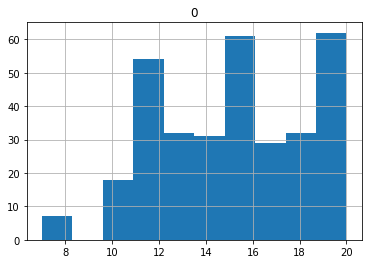

In [ ]:
dataset_fwd_train.get_items_info().hist()

In [ ]:
batch_size = 16

In [ ]:
dataloader_general_train = DataLoader(dataset_general_train, batch_size=batch_size, shuffle=False)
dataloader_general_valid = DataLoader(dataset_general_valid, batch_size=batch_size, shuffle=False)

dataloader_gk_train = DataLoader(dataset_gk_train, batch_size=batch_size, shuffle=False)
dataloader_def_train = DataLoader(dataset_def_train, batch_size=batch_size, shuffle=False)
dataloader_mid_train = DataLoader(dataset_mid_train, batch_size=batch_size, shuffle=False)
dataloader_fwd_train = DataLoader(dataset_fwd_train, batch_size=batch_size, shuffle=False)

dataloader_gk_valid = DataLoader(dataset_gk_valid, batch_size=batch_size, shuffle=False)
dataloader_def_valid = DataLoader(dataset_def_valid, batch_size=batch_size, shuffle=False)
dataloader_mid_valid = DataLoader(dataset_mid_valid, batch_size=batch_size, shuffle=False)
dataloader_fwd_valid = DataLoader(dataset_fwd_valid, batch_size=batch_size, shuffle=False)

In [ ]:
len(dataloader_general_train), len(dataloader_gk_train), len(dataloader_def_train), len(dataloader_mid_train), len(dataloader_fwd_train)

(182, 18, 62, 83, 21)

In [ ]:
len(dataloader_general_valid), len(dataloader_gk_valid), len(dataloader_def_valid), len(dataloader_mid_valid), len(dataloader_fwd_valid)

(18, 2, 7, 8, 2)

# LSTM Model

In [ ]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

# Training loops

In [ ]:
criterion = nn.MSELoss()

In [ ]:
def train_net(net, num_epochs, dataloader_train, dataloader_valid, optimizer):
    if len(dataloader_train) <= 0:
        print("Dataloader has no elements")
        return []

    best_model = None
    best_val_loss = None

    loss_history_train = []
    loss_history_valid = []

    for epoch in range(num_epochs):
        running_loss_train = 0
        running_loss_valid = 0

        # training
        for i, (inputs, targets) in enumerate(dataloader_train):
            inputs = torch.flatten(inputs, 1, 2)
            inputs = inputs.unsqueeze(2).to(device)
            targets = targets.to(device)
            # print("INPUTS", inputs.shape)
            # print("TARGETS", targets.shape)
            # print(targets)
            optimizer.zero_grad()
            outputs = net(inputs).flatten().to(device)
            # print("OUTPUTS", outputs.shape)
            loss = criterion(outputs, targets)
            running_loss_train += loss.item()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
          # valid
          for i, (inputs, targets) in enumerate(dataloader_valid):
              inputs = torch.flatten(inputs, 1, 2)
              inputs = inputs.unsqueeze(2).to(device)
              targets = targets.to(device)
              # print("INPUTS", inputs.shape)
              # print("TARGETS", targets.shape)
              # print(targets)
              optimizer.zero_grad()
              outputs = net(inputs).flatten().to(device)
              # print("OUTPUTS", outputs.shape)
              loss = criterion(outputs, targets)
              running_loss_valid += loss.item()

        epoch_valid_loss = running_loss_valid / len(dataloader_valid)

        loss_history_train.append(running_loss_train / len(dataloader_train))
        loss_history_valid.append(epoch_valid_loss)

        if not best_model or epoch_valid_loss < best_val_loss:
            best_model = net
            best_val_loss = epoch_valid_loss


        if epoch % 5 == 0:
            print(f'Epoch {epoch} Train: {running_loss_train / len(dataloader_train)} Valid: {running_loss_valid / len(dataloader_valid)}')
    
    return loss_history_train, loss_history_valid, best_model

In [ ]:
def plot_loss_history(loss_history_train, loss_history_valid):
    plt.plot(loss_history_train, color='blue', label='Training Loss')
    plt.plot(loss_history_valid, color='orange', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Training loop - general net

In [ ]:
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
if not train_general:
    net.load_state_dict(torch.load('models/best/best_lstm_general.pt'))
    best_model_general = net

In [ ]:
%%time
if train_general:
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    loss_history_train, loss_history_valid, best_model_general = train_net(net, 10, dataloader_general_train, dataloader_general_valid, optimizer)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [ ]:
if train_general:
    plot_loss_history(loss_history_train, loss_history_valid)

## Training loop - goalkeeper net

In [ ]:
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
if not train_gk:
    net_gk.load_state_dict(torch.load('models/best/best_lstm_gk.pt'))
    best_model_gk = net_gk

In [ ]:
%%time
if train_gk:
    optimizer_gk = optim.Adam(net_gk.parameters(), lr=0.01)
    loss_history_gk_train, loss_history_gk_valid, best_model_gk = train_net(net_gk, 5, dataloader_gk_train, dataloader_gk_valid, optimizer_gk)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [ ]:
if train_gk:
    plot_loss_history(loss_history_gk_train, loss_history_gk_valid)

## Training loop - defender net

In [ ]:
net_def = LSTMNetwork(1, 8, 2, 1, dropout=0.5).to(device)
if not train_def:
    net_def.load_state_dict(torch.load('models/best/best_lstm_def.pt'))
    best_model_def = net_def

In [ ]:
%%time
if train_def:
    optimizer_def = optim.Adam(net_def.parameters(), lr=0.0001)
    loss_history_def_train, loss_history_def_valid, best_model_def = train_net(net_def, 150, dataloader_def_train, dataloader_def_valid, optimizer_def)

Epoch 0 Train: 13.654262366794772 Valid: 17.323420115879603
Epoch 5 Train: 12.759741238047999 Valid: 16.15521948678153
Epoch 10 Train: 10.862825365797166 Valid: 13.651215757642474
Epoch 15 Train: 9.519277166935705 Valid: 11.87653112411499
Epoch 20 Train: 8.871797190558526 Valid: 10.96633059637887
Epoch 25 Train: 8.5685668107002 Valid: 10.59257561819894
Epoch 30 Train: 8.341875447380927 Valid: 10.185844625745501
Epoch 35 Train: 8.269359161776881 Valid: 9.800232546670097
Epoch 40 Train: 8.27640434618919 Valid: 9.817213875906807
Epoch 45 Train: 8.234742983695 Valid: 9.699410574776786
Epoch 50 Train: 8.210295934830942 Valid: 9.648048400878906
Epoch 55 Train: 8.20106937039283 Valid: 9.52602297919137
Epoch 60 Train: 8.205229409279362 Valid: 9.474440506526403
Epoch 65 Train: 8.206334587066404 Valid: 9.523468494415283
Epoch 70 Train: 8.206728754505034 Valid: 9.625057424817767
Epoch 75 Train: 8.216376216180864 Valid: 9.462287902832031
Epoch 80 Train: 8.199386419788484 Valid: 9.569711140223912
E

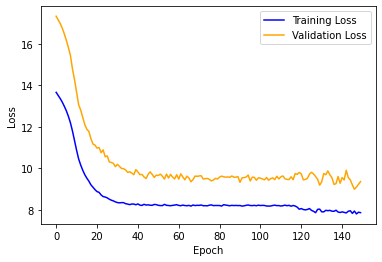

In [ ]:
if train_def:    
    plot_loss_history(loss_history_def_train, loss_history_def_valid)

## Training loop - midfielder net

In [ ]:
net_mid = LSTMNetwork(1, 15, 2, 1, dropout=0.4).to(device)
if not train_mid:
    net_mid.load_state_dict(torch.load('models/best/best_lstm_mid.pt'))
    best_model_mid = net_mid

In [ ]:
%%time
if train_mid:
    optimizer_mid = optim.Adam(net_mid.parameters(), lr=0.0001)
    loss_history_mid_train, loss_history_mid_valid, best_model_mid = train_net(net_mid, 300, dataloader_mid_train, dataloader_mid_valid, optimizer_mid)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [ ]:
if train_mid:
    plot_loss_history(loss_history_mid_train, loss_history_mid_valid)

## Training loop - forward net

In [ ]:
net_fwd = LSTMNetwork(1, 8, 2, 1, dropout=0.5).to(device)
if not train_fwd:
    net_fwd.load_state_dict(torch.load('models/best/best_lstm_fwd.pt'))
    best_model_fwd = net_fwd

In [ ]:
%%time
if train_fwd:
    optimizer_fwd = optim.Adam(net_fwd.parameters(), lr=0.0001)
    loss_history_fwd_train, loss_history_fwd_valid, best_model_fwd = train_net(net_fwd, 1500, dataloader_fwd_train, dataloader_fwd_valid, optimizer_fwd)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [ ]:
if train_fwd:
    plot_loss_history(loss_history_fwd_train, loss_history_fwd_valid)

# Saving models to files

In [ ]:
# general model
torch.save(net.state_dict(), 'models/regular/lstm_general.pt')
torch.save(best_model_general.state_dict(), 'models/best/best_lstm_general.pt')

# positional models
if train_gk:
    torch.save(net_gk.state_dict(), 'models/regular/lstm_gk.pt')
    torch.save(best_model_gk.state_dict(), 'models/best/best_lstm_gk.pt')

if train_def:
    torch.save(net_def.state_dict(), 'models/regular/lstm_def.pt')
    torch.save(best_model_def.state_dict(), 'models/best/best_lstm_def.pt')

if train_mid:
    torch.save(net_mid.state_dict(), 'models/regular/lstm_mid.pt')
    torch.save(best_model_mid.state_dict(), 'models/best/best_lstm_mid.pt')

if train_fwd:
    torch.save(net_fwd.state_dict(), 'models/regular/lstm_fwd.pt')
    torch.save(best_model_fwd.state_dict(), 'models/best/best_lstm_fwd.pt')

# Next GW predictions - general model

In [ ]:
def generate_predictions(dataloader_pos, dataset_pos, net_pos, df_original, first_gw):
    index = 0
    predictions_pos = []
    for inputs, target in dataloader_pos:
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2).to(device)

        # print("Inputs", inputs)
        # print("Target", target)
        # print("INPUTS", inputs)
        # print(inputs)
        outputs = net_pos(inputs).to(device)
        # print("OUTPUTS", outputs)
        for output in outputs:
            player_id, sample_id = dataset_pos.index_table[index]
            name = dataset_pos.names[player_id]
            points = round(output.item(), 2)
            # print("DFORW NEXT", player_id, sample_id, name, points)
            df_row = df_original[(df_original["Name"] == name) & (df_original["GW"] >= first_gw)].iloc[sample_id]
            # print("DFROW", df_row)
            df_row["Points"] = points
            df_gw = df_row["GW"]
            df_opp = df_row["Opponent"]

            # print("GEN PRED", player_id, sample_id, name, points, df_gw, df_opp)
            
            gw = sample_id + FIS + 1 # wrong
            predictions_pos.append(df_row)
            # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
            index += 1
    
    output_df = pd.DataFrame(predictions_pos)
    output_df = output_df.loc[:, ~output_df.columns.str.contains('^Unnamed')]
    return output_df

In [ ]:
prediction_columns = ["Name", "GW", "Opponent", "Was Home", "Total Points", "Points"]

In [ ]:
predictions = generate_predictions(dataloader_general_valid, dataset_general_valid, net, df_original, FIRST_VALID_GW)

In [ ]:
# dataset_general_valid.__getitem__(279)

In [ ]:
predictions.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
5704,Marc-Roca,21,Brentford,1.0,3.0,2.83
4079,Douglas-Luiz,21,Southampton,0.0,5.0,2.83
3325,Mathias-Jensen,21,Leeds United,0.0,3.0,2.83
1756,Kiernan-Dewsbury-Hall,21,Brighton,1.0,2.0,2.82
2748,Jack-Grealish,21,Wolves,1.0,3.0,2.82
6480,Pascal-Struijk,21,Brentford,1.0,6.0,2.82
6516,Sam-Surridge,21,Bournemouth,0.0,8.0,2.82
3185,Pierre-Hojbjerg,21,Fulham,0.0,3.0,2.82
3090,Son-Heung-min,21,Fulham,0.0,5.0,2.82
1720,Leander-Dendoncker,21,Southampton,0.0,1.0,2.82


In [ ]:
# # appending results to original df
# for df_gw, df_opp, name, gw, points in predictions:
#     df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

# Next GW predictions for each position

## Goalkeepers

In [ ]:
predictions_gk = generate_predictions(dataloader_gk_valid, dataset_gk_valid, best_model_gk, df_gk_original, FIRST_VALID_GW)

In [ ]:
# results sorted
predictions_gk_sorted = predictions_gk.sort_values(by=["Points"], ascending = False).head(20)
predictions_gk_sorted[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
2409,Fraser-Forster,21,Fulham,0.0,0.0,3.14
4603,Illan-Meslier,21,Brentford,1.0,6.0,3.12
5863,Jose-Sa,21,Manchester City,0.0,2.0,3.11
391,Alphonse-Areola,21,Everton,1.0,0.0,3.11
5351,Jordan-Pickford,21,West Ham,0.0,1.0,3.10
467,Kepa-Arrizabalaga,21,Liverpool,0.0,9.0,3.10
2806,Vicente-Guaita,21,Newcastle Utd,1.0,10.0,3.10
4335,Emiliano-Martinez,21,Southampton,0.0,10.0,3.10
4000,Hugo-Lloris,21,Fulham,0.0,9.0,3.09
6011,Robert-Sanchez,21,Leicester City,0.0,1.0,3.09


## Defenders

In [ ]:
predictions_def = generate_predictions(dataloader_def_valid, dataset_def_valid, best_model_def, df_def_original, FIRST_VALID_GW)

In [ ]:
# results sorted
predictions_def_sorted = predictions_def.sort_values(by=["Points"], ascending = False).head(20)
predictions_def_sorted[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
6131,Nelson-Semedo,21,Manchester City,0.0,1.0,2.58
3841,Clement-Lenglet,21,Fulham,0.0,0.0,2.56
2010,Lewis-Dunk,21,Leicester City,0.0,1.0,2.56
5685,Antonee-Robinson,21,Tottenham,1.0,2.0,2.55
3584,Max-Kilman,21,Manchester City,0.0,0.0,2.55
1331,Conor-Coady,21,West Ham,0.0,1.0,2.54
195,Trent-Alexander-Arnold,21,Chelsea,1.0,1.0,2.54
4537,Ben-Mee,21,Leeds United,0.0,6.0,2.54
979,Dan-Burn,21,Crystal Palace,0.0,6.0,2.54
6781,Kieran-Trippier,21,Crystal Palace,0.0,8.0,2.53


## Midfielders

In [ ]:
predictions_mid = generate_predictions(dataloader_mid_valid, dataset_mid_valid, best_model_mid, df_mid_original, FIRST_VALID_GW)

In [ ]:
# results sorted
predictions_mid_sorted = predictions_mid.sort_values(by=["Points"], ascending = False).head(20)
predictions_mid_sorted[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
5496,Marcus-Rashford,21,Arsenal,0.0,7.0,4.66
5895,Bukayo-Saka,21,Manchester Utd,1.0,9.0,4.62
4263,Solly-March,21,Leicester City,0.0,2.0,4.62
7456,Martin-Odegaard,21,Manchester Utd,1.0,5.0,4.60
4701,Kaoru-Mitoma,21,Leicester City,0.0,10.0,4.60
655,Harvey-Barnes,21,Brighton,1.0,7.0,4.59
4316,Martinelli,21,Manchester Utd,1.0,2.0,4.59
2731,Demarai-Gray,21,West Ham,0.0,2.0,4.59
5762,Rodrigo,21,Brentford,1.0,2.0,4.57
4163,Riyad-Mahrez,21,Wolves,1.0,6.0,4.57


## Forwards

In [ ]:
predictions_fwd = generate_predictions(dataloader_fwd_valid, dataset_fwd_valid, best_model_fwd, df_fwd_original, FIRST_VALID_GW)

In [ ]:
# results sorted
predictions_fwd_sorted = predictions_fwd.sort_values(by=["Points"], ascending = False).head(30)
predictions_fwd_sorted[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
38,Che-Adams,21,Aston Villa,1.0,2.0,4.23
4718,Aleksandar-Mitrovic,21,Tottenham,1.0,2.0,4.22
3501,Harry-Kane,21,Fulham,0.0,6.0,4.21
2904,Erling-Haaland,21,Wolves,1.0,17.0,4.16
7121,Danny-Welbeck,21,Leicester City,0.0,2.0,4.15
6714,Ivan-Toney,21,Leeds United,0.0,1.0,4.09
2967,Kai-Havertz,21,Liverpool,0.0,2.0,4.09
4443,Bryan-Mbeumo,21,Leeds United,0.0,2.0,4.05
3401,Brennan-Johnson,21,Bournemouth,0.0,5.0,3.02
7212,Callum-Wilson,21,Crystal Palace,0.0,2.0,2.98


# Saving predictions to files

In [ ]:
predictions.to_csv("predictions/predictions_general.csv")

predictions_gk_sorted.to_csv("predictions/predictions_gk.csv")
predictions_def_sorted.to_csv("predictions/predictions_def.csv")
predictions_mid_sorted.to_csv("predictions/predictions_mid.csv")
predictions_fwd_sorted.to_csv("predictions/predictions_fwd.csv")

# Predictions for train dataloaders



## General model

In [ ]:
train_predictions_general = generate_predictions(dataloader_general_train, dataset_general_train, net, df_original, FIRST_TRAIN_GW)

In [ ]:
train_predictions_general.to_csv("predictions/train_predictions_general.csv")

## Positional models

In [ ]:
train_predictions_gk = generate_predictions(dataloader_gk_train, dataset_gk_train, net_gk, df_gk_original, FIRST_TRAIN_GW)

In [ ]:
train_predictions_def = generate_predictions(dataloader_def_train, dataset_def_train, net_def, df_def_original, FIRST_TRAIN_GW)

In [ ]:
train_predictions_mid = generate_predictions(dataloader_mid_train, dataset_mid_train, net_mid, df_mid_original, FIRST_TRAIN_GW)

In [ ]:
train_predictions_fwd = generate_predictions(dataloader_fwd_train, dataset_fwd_train, net_fwd, df_fwd_original, FIRST_TRAIN_GW)

In [ ]:
train_predictions_gk.to_csv("predictions/train_predictions_gk.csv")
train_predictions_def.to_csv("predictions/train_predictions_def.csv")
train_predictions_mid.to_csv("predictions/train_predictions_mid.csv")
train_predictions_fwd.to_csv("predictions/train_predictions_fwd.csv")

In [ ]:
train_predictions_fwd[prediction_columns]["Name"].unique()

array(['Che-Adams', 'Julian-Alvarez', 'Michail-Antonio', 'Adam-Armstrong',
       'Taiwo-Awoniyi', 'Patson-Daka', 'Emmanuel-Dennis',
       'Odsonne-Edouard', 'Joe-Gelhardt', 'Sam-Greenwood',
       'Erling-Haaland', 'Kai-Havertz', 'Kelechi-Iheanacho', 'Danny-Ings',
       'Brennan-Johnson', 'Harry-Kane', 'Sekou-Mara',
       'Jean-Philippe-Mateta', 'Neal-Maupay', 'Bryan-Mbeumo',
       'Aleksandar-Mitrovic', 'Kieffer-Moore', 'Eddie-Nketiah',
       'Gianluca-Scamacca', 'Dominic-Solanke', 'Sam-Surridge',
       'Ivan-Toney', 'Deniz-Undav', 'Jamie-Vardy', 'Carlos-Vinicius',
       'Ollie-Watkins', 'Danny-Welbeck', 'Callum-Wilson', 'Chris-Wood'],
      dtype=object)

In [ ]:
len(df_fwd_original[df_fwd_original["GW"] == 21]["Name"].unique())

42

In [ ]:
len(train_predictions_fwd)

326